<a href="https://colab.research.google.com/github/singhsukhendra/Mytest/blob/master/Copy_of_Breast_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# We need pillow version of 5.3.0
# We will uninstall the older version first
!pip uninstall -y Pillow
# Install the new one
!pip install Pillow==5.3.0
# Let's verify the version
# This should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime
!pip install image
# !pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
import PIL
print(PIL.PILLOW_VERSION)

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


5.3.0


In [0]:
# We will verify that GPU is enabled for this notebook
# Following should print: CUDA is available!  Training on GPU ...
# if it prints otherwise, then you need to enable GPU: 
# From Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [0]:
# I made a smaller version of the dataset, original one has classes and subclasses.
# I just wanted to keep 2 classes: Benign and Malignant.
#Download and unzip de folder
!gdown https://drive.google.com/uc?id=1r6YNGwijUHawsRHKy8qQk12FW-VQXw4p
!unzip -qq b_cancer_data2.zip

Downloading...
From: https://drive.google.com/uc?id=1r6YNGwijUHawsRHKy8qQk12FW-VQXw4p
To: /content/b_cancer_data2.zip
4.28GB [00:28, 150MB/s]
replace b_cancer_data2/train/BENIGN/desktop.ini? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
#Organizing the dataset
data_dir = '/b_cancer_data2'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

In [0]:
!git clone https://github.com/viritaromero/Breast-Cancer-Detection.git

fatal: destination path 'Breast-Cancer-Detection' already exists and is not an empty directory.


In [0]:
import json

with open('cate.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder

data_dir = 'b_cancer_data2'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

class_names = image_datasets['train'].classes


In [0]:
# Build and train your network

# 1. Load resnet-152 pre-trained network
model = models.resnet152(pretrained=True)
# Freeze parameters so we don't backprop through them

for param in model.parameters():
    param.requires_grad = False

#Let's check the model architecture:
    print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
# 2. Define a new, untrained feed-forward network as a classifier, using ReLU activations

# Our input_size matches the in_features of pretrained model


from collections import OrderedDict


# Creating the classifier ordered dictionary first

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(512, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
model.fc = classifier

In [0]:
#Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# Train a model with a pre-trained network
num_epochs = 5
if use_gpu:
  print ("Using GPU: "+ str(use_gpu))
  model = model.cuda()
    

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
#optimizer = optim.Adam(model.fc.parameters(), lr=0.005)
optimizer = optim.SGD(model.fc.parameters(), lr = .0006, momentum=0.9)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Using GPU: True
Epoch 1/5
----------
train Loss: 0.5329 Acc: 0.7415
valid Loss: 0.5018 Acc: 0.7225

Epoch 2/5
----------
train Loss: 0.4198 Acc: 0.8295
valid Loss: 0.3933 Acc: 0.8421

Epoch 3/5
----------
train Loss: 0.3679 Acc: 0.8530
valid Loss: 0.3603 Acc: 0.8600

Epoch 4/5
----------
train Loss: 0.3388 Acc: 0.8667
valid Loss: 0.3185 Acc: 0.8919

Epoch 5/5
----------
train Loss: 0.3243 Acc: 0.8741
valid Loss: 0.3292 Acc: 0.8766

Training complete in 8m 56s
Best valid accuracy: 0.891944


In [0]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['valid']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])))

In [0]:
test(model, dataloaders, device)

Testing Accuracy: 0.017
Testing Accuracy: 0.036
Testing Accuracy: 0.054
Testing Accuracy: 0.071
Testing Accuracy: 0.089
Testing Accuracy: 0.108
Testing Accuracy: 0.126
Testing Accuracy: 0.145
Testing Accuracy: 0.163
Testing Accuracy: 0.182
Testing Accuracy: 0.200
Testing Accuracy: 0.219
Testing Accuracy: 0.236
Testing Accuracy: 0.256
Testing Accuracy: 0.272
Testing Accuracy: 0.291
Testing Accuracy: 0.311
Testing Accuracy: 0.331
Testing Accuracy: 0.350
Testing Accuracy: 0.369
Testing Accuracy: 0.386
Testing Accuracy: 0.403
Testing Accuracy: 0.423
Testing Accuracy: 0.441
Testing Accuracy: 0.459
Testing Accuracy: 0.478
Testing Accuracy: 0.494
Testing Accuracy: 0.512
Testing Accuracy: 0.532
Testing Accuracy: 0.547
Testing Accuracy: 0.566
Testing Accuracy: 0.585
Testing Accuracy: 0.602
Testing Accuracy: 0.619
Testing Accuracy: 0.638
Testing Accuracy: 0.654
Testing Accuracy: 0.671
Testing Accuracy: 0.689
Testing Accuracy: 0.707
Testing Accuracy: 0.726
Testing Accuracy: 0.744
Testing Accuracy

In [0]:
# Save the checkpoint 

model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, '8960_checkpoint.pth')

In [0]:
#Load the trained model from here:
!gdown https://drive.google.com/uc?id=16RqsH1oCROSJiCR0f2gWCs4Xaz3JRTw9
#https://drive.google.com/open?id=16RqsH1oCROSJiCR0f2gWCs4Xaz3JRTw9

Downloading...
From: https://drive.google.com/uc?id=16RqsH1oCROSJiCR0f2gWCs4Xaz3JRTw9
To: /content/8960_checkpoint.pth
242MB [00:01, 220MB/s]


In [0]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # Our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 2
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint('8960_checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [0]:
def predict(image_path, model, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

In [0]:
def forecast(image_path,model,topk=2):
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    
    
   
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]
    print("malignancy prob",top_probability[0])
    print("benign prob",top_probability[1])
    
    if top_probability[0]>top_probability[1]:
      print("unfortunately there are more chances of malignancy")
    else:
      print("no worries,benign tumour")
  

In [0]:
print (predict('b_cancer_data2/valid/MALIGNANT/SOB_M_DC-14-2985-200-007.png', loaded_model))

(array([0.8490989 , 0.15090117], dtype=float32), ['MALIGNANT', 'BENIGN'])


In [0]:
forecast('b_cancer_data2/valid/MALIGNANT/SOB_M_DC-14-2985-200-007.png', loaded_model)

malignancy prob 0.8490989
benign prob 0.15090117
unfortunately there are more chances of malignancy


In [0]:
forecast('SOB_B_A-14-22549AB-40-023.png', loaded_model)

malignancy prob 0.5184539
benign prob 0.4815461
unfortunately there are more chances of malignancy


In [0]:
# Display an image along with the top 2 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    cancer_type = mapper[img_filename]
    
    ax1.set_title(cancer_type)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

malignancy prob 0.8490989
benign prob 0.15090117
unfortunately there are more chances of malignancy


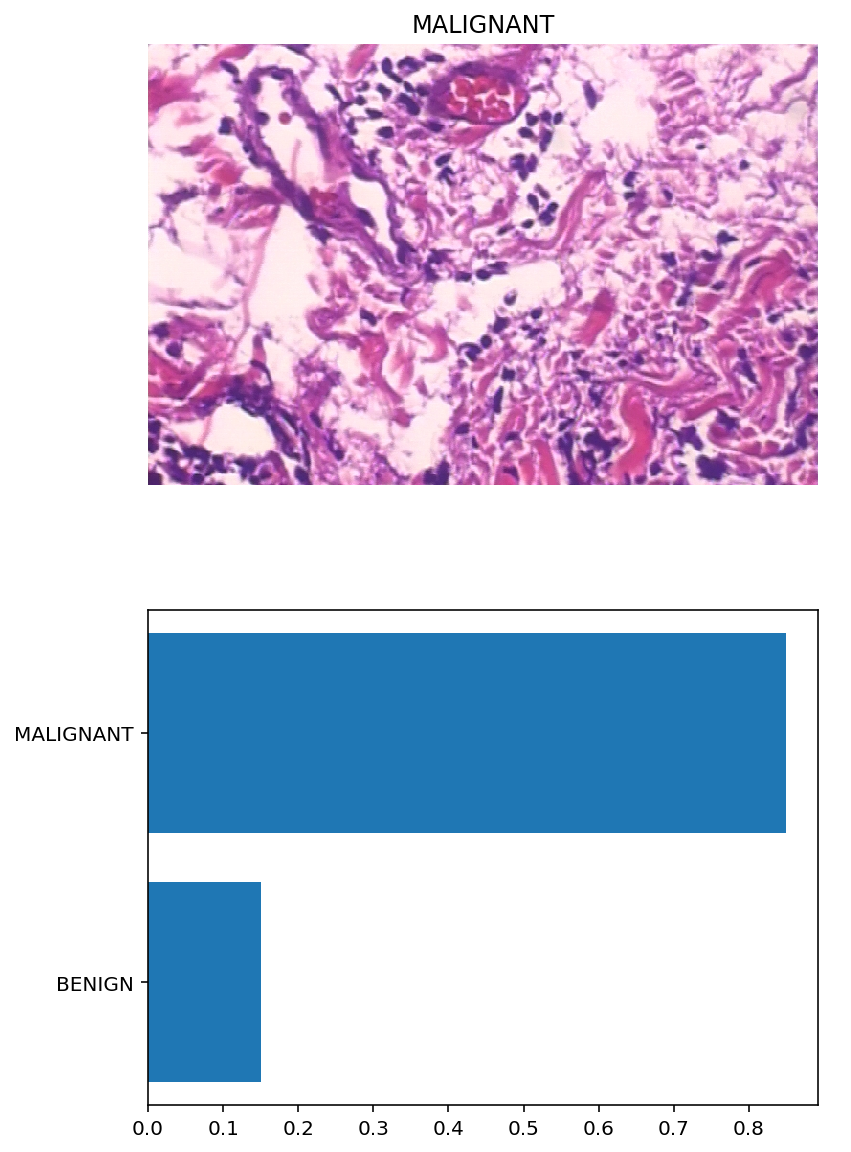

In [0]:
img = 'b_cancer_data2/valid/MALIGNANT/SOB_M_DC-14-2985-200-007.png'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)
forecast(img,loaded_model)

malignancy prob 0.7776601
benign prob 0.22233997
unfortunately there are more chances of malignancy


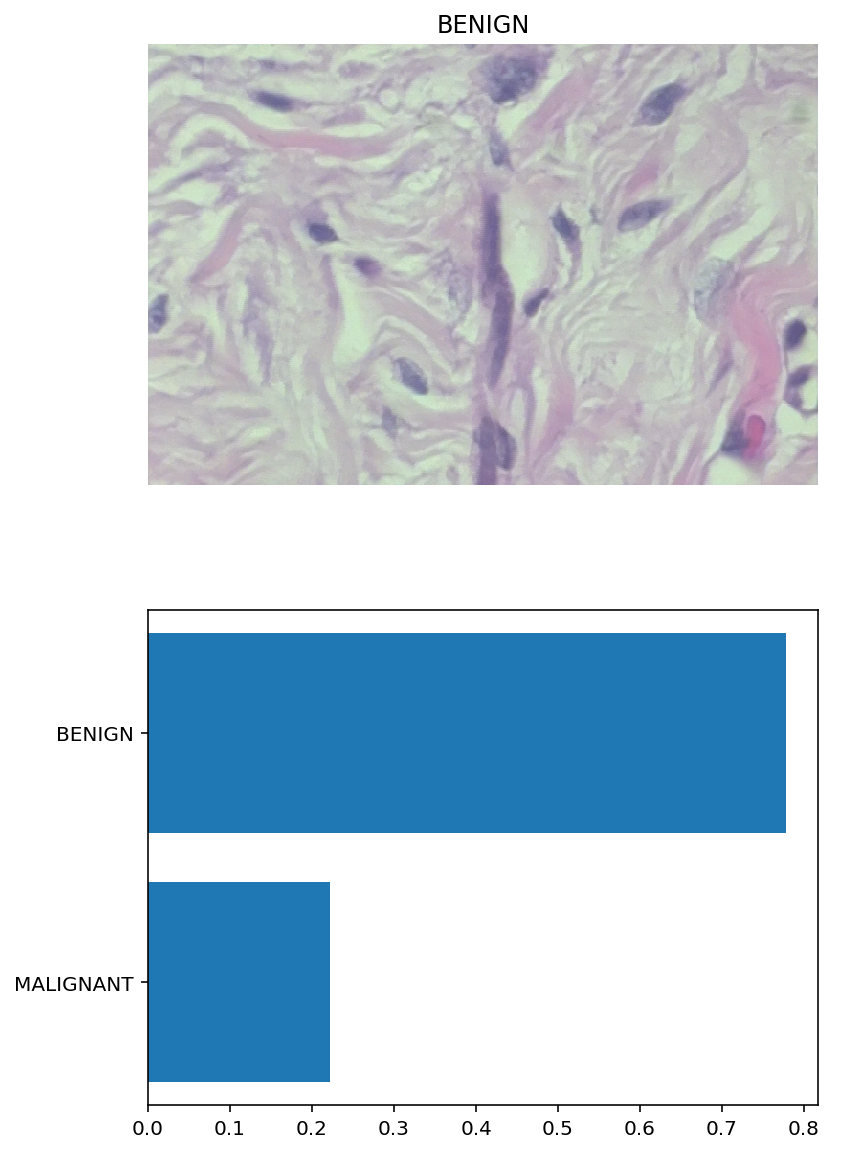

In [0]:
img = 'b_cancer_data2/valid/BENIGN/SOB_B_A-14-22549AB-400-005.png'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)
forecast(img,loaded_model)

malignancy prob 0.7882912
benign prob 0.21170878
unfortunately there are more chances of malignancy


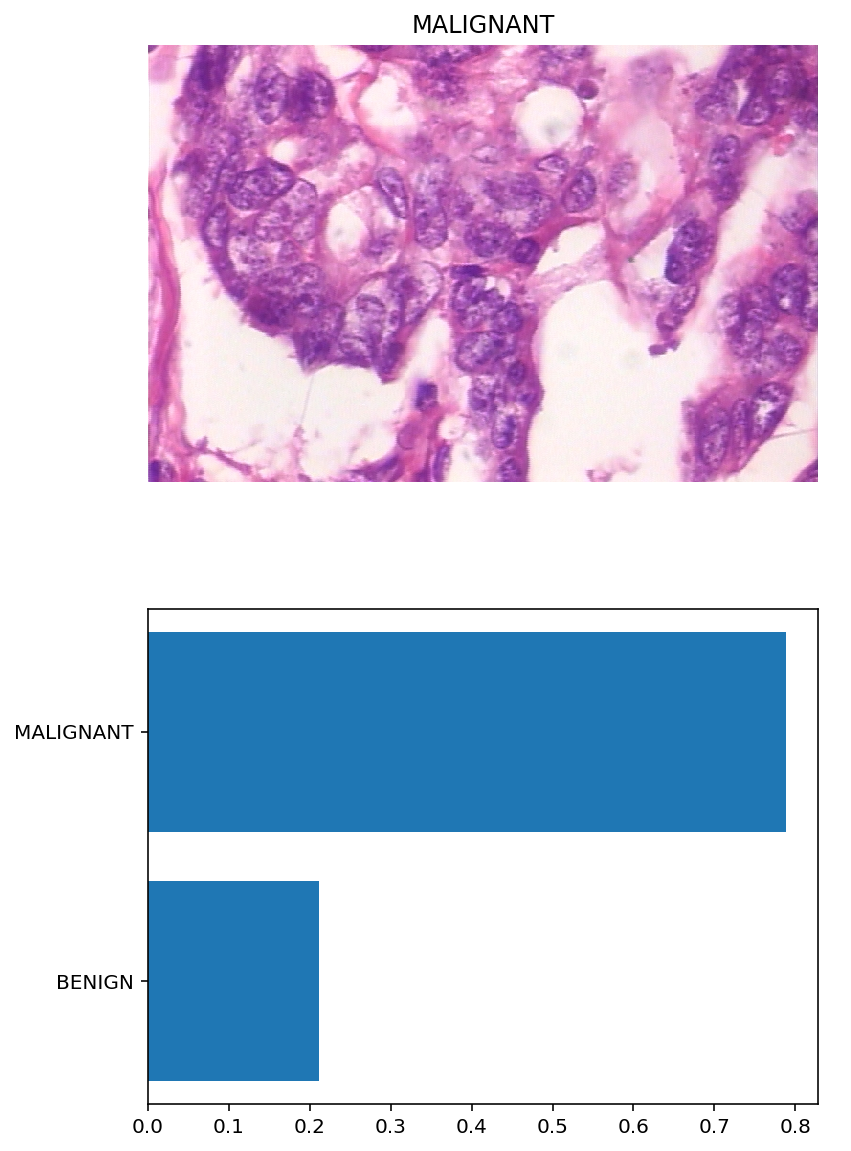

In [0]:
img = 'b_cancer_data2/valid/MALIGNANT/SOB_M_PC-14-12465-400-013.png'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)
forecast(img,loaded_model)

IndexError: ignored

In [0]:
!ls


In [0]:
listoffiles=['1.png','2.png','3.png','4.png','5.png','6.png']
for x in listoffiles:
  img = x
  p, c = predict(img, loaded_model)
  #view_classify(img, p, c, cat_to_name)
  forecast(img,loaded_model)
             

unfortunately there are more chances of malignancy
unfortunately there are more chances of malignancy
unfortunately there are more chances of malignancy
unfortunately there are more chances of malignancy
unfortunately there are more chances of malignancy
unfortunately there are more chances of malignancy
